In [10]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(model_name="gpt-4o-mini")

In [5]:
# schema (rules)   for the essay workflow
class EvaluationSchema(BaseModel):
    Feedback : str = Field( description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 10 for the essay",ge=0, le=10) # greater than or equal to 0 and less than or equal to 10

In [6]:
structuredModel = model.with_structured_output(EvaluationSchema)

In [7]:
essay = """
I’m from a middle-class family of Bihar, I am Naresh Shukla. Nobody comes in this world, without the support of family and friends. Actually, whatever you will be, it is just because of your family. My father is a respectable businessman in our community.

My mother is a doctor. They both love their occupation. That’s I have learned from my parents the value of time, honesty, hard work and commitment to the purpose.

We are three brothers and sisters. Being the eldest I am the most liable from my brothers and sisters. I am wanted to guide and take care of my other siblings. We all are in the same school. Reading is my passion.

I am a keen reader of novels and history books as I have a strong interest in Indian History and classical architecture. I love to read books that refer to the rich history and civilization of ancient India. At my pre-childhood, I used to listen to stories from my grandmother, and this has a long-lasting effect on me.

Get the huge list of more than 500 Essay Topics and Ideas

My Education
I am studying at the best school in my city. I am presently in class 10th. I feel happy to be a part of this great school with the good friends, helpful and loving teacher and sound school administration. I have extraordinary skills in some subjects whereas I am very weak in the few.

My Strengths
In compare to studies, I am good at sports. so I am the captain of my class football team. I am the best football player at my school. Besides this, I am a fast runner also and I love athletics. I am in expert swimming. I have won many medals in swimming at the school level. I am also good at music and dance. I have a melodious voice and I sing very well. I have won many prizes in singing competitions at the school level.
The advice of my parents had a keen effect on my habits. I believe to speak the truth and try my best not to lie. My parents always advised me that if I commit a mistake, I should admit it. I try my best to do so. I know how to remain happy in every condition. Because I believe that: “Happiness is not out there; it’s in you.”

I am a very adventurous person too and like to take the risk. I like to do a creative thing besides doing old stuff again and again. Learning new things is one thing which I always enjoy. I always update myself with the news.

Along with this, I fond of reading a few children magazines in which different motivational stories are there. They taught me a high moral lesson. I am a very confident person and know how to talk. I always try to speak to every person according to his requirement so I understand people.

My Weaknesses
As every man have weaknesses, so have also. I am a little bit lazy at some places which I do not like. While playing time, I pass my lot of time there which is not a good habit, but I try my best to overcome my weaknesses.

My Ambitions in Life
Everybody has an ambition in life. Aim or ambition is the inner aspiration of man. No man can do anything in the world without aim. So, all of us should be very determined about our aim in life.

Without good career planning, right from the start, one can’t be on the right track. One has to set the goals in accordance with his or her broad career goals.

I have studied biology and I will seat for the competitive entrance exam for admission to reputed medical college. I shall try to be a good and honest student. Then I shall be a qualified doctor. I will do all that to be a good doctor and will be sincere to it.

Conclusion
These are all the things which express me. Though nobody can be described in a few sets of sentences. One needs to have yet command of oneself before going to write something about his life. Life is meant to be lived avidly and with visualization to do good for your fellow beings. Keeping this aim in mind, I have always desired to serve my people in whatever capacity I can.

"""

In [13]:
prompy = f'Evalate the language quality of the following essay and provide a feedback and a score out of 10. \n\nEssay:\n"""\n{essay}\n"""'

structuredModel.invoke(prompy)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [11]:
class UPSCState(TypedDict):
    essay : str
    clarity_feedback: str  # clearity of throught in essay
    language_feedback: str 
    analysis_feedback: str
    overall_feedback : str
    individual_scores: Annotated[list[int], operator.add]  # individual scores for clarity, language, analysis added correctly  so that no overrite happens
    average_score: float


In [17]:
def evaluate_clarity(state: UPSCState) -> UPSCState:
    prompt = f'Evalate the clarity of thought of the following essay and provide a feedback and a score out of 10. \n\nEssay:\n"""\n{state["essay"]}\n"""'
    output = structuredModel.invoke(prompt)
   
    return {'clarity_feedback': output.Feedback, 'individual_scores': [output.score]}

def evaluate_analysis(state: UPSCState) -> UPSCState:
    prompt = f'Evalate the depth of analysis of the following essay and provide a feedback and a score out of 10. \n\nEssay:\n"""\n{state["essay"]}\n"""'
    output = structuredModel.invoke(prompt)
   
    return {'analysis_feedback': output.Feedback, 'individual_scores': [output.score]}


def evaluate_language(state: UPSCState) -> UPSCState:
    prompt = f'Evalate the language quality of the following essay and provide a feedback and a score out of 10. \n\nEssay:\n"""\n{state["essay"]}\n"""'
    output = structuredModel.invoke(prompt)
   
    return {'language_feedback': output.Feedback, 'individual_scores': [output.score]}


def final_evaluation(state: UPSCState) -> UPSCState:
    # summary feedback 
    prompt = f" Based on the following feedbacks create a summarized feedback \n Clarity Feedback: {state['clarity_feedback']}\nLanguage Feedback: {state['language_feedback']}\nAnalysis Feedback: {state['analysis_feedback']}"
    overall_feedback = model.invoke(prompt).content

    # average calculate
    average_score = sum(state['individual_scores']) / len(state['individual_scores'])
    return {'overall_feedback': overall_feedback, 'average_score': average_score}

In [19]:
# dfeine graph
graph = StateGraph(UPSCState)

# add nodes
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_language)
graph.add_node('final_evaluation', final_evaluation)

# add edges
graph.add_edge(START, 'evaluate_clarity')
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')


graph.add_edge('evaluate_clarity', 'final_evaluation')
graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()


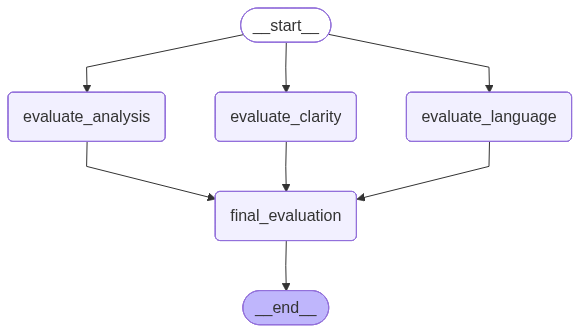

In [20]:
workflow

In [21]:
initial_state: UPSCState = {
    'essay': essay
}

workflow.invoke(initial_state)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}